In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path
from skimage.io import imread
from skimage.color import label2rgb
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
malaria_dir_str = '../raw_data/task_1/vivax_binary/'
malaria_dir = Path(malaria_dir_str)
import matplotlib.patches as patches

In [3]:
!pwd

/home/pmachado3/code/DDS_bootcamp_project/Malaria_Tracker/jupyter_notebook


In [4]:
malaria_dir

PosixPath('../raw_data/task_1/vivax_binary')

In [5]:
train_df = pd.read_json(malaria_dir / 'training.json')
train_df['path'] = train_df['image'].map(lambda x: malaria_dir / x['pathname'][1:])
train_df['image_available'] = train_df['path'].map(lambda x: x.exists())
print(train_df.shape[0], 'images')
train_df = train_df.query('image_available')
print(train_df.shape[0], 'images available')
train_df.sample(5)

1208 images
1208 images available


image  \
306   {'checksum': '074e8b12c0329dac7a65bda686bc4b83...   
506   {'checksum': '007410faaad7711a65384e6bbc6e19de...   
974   {'checksum': '54032923684f88143978113f9780d898...   
1071  {'checksum': 'cca35e945590d3e1cb9fef0eed4aad44...   
65    {'checksum': '92d912703d9ba7984f4dc6b5e7dbaaf5...   

                                                objects  \
306   [{'bounding_box': {'minimum': {'r': 956, 'c': ...   
506   [{'bounding_box': {'minimum': {'r': 1082, 'c':...   
974   [{'bounding_box': {'minimum': {'r': 998, 'c': ...   
1071  [{'bounding_box': {'minimum': {'r': 312, 'c': ...   
65    [{'bounding_box': {'minimum': {'r': 208, 'c': ...   

                                                   path  image_available  
306   ../raw_data/task_1/vivax_binary/images/bb337c8...             True  
506   ../raw_data/task_1/vivax_binary/images/d31dd2c...             True  
974   ../raw_data/task_1/vivax_binary/images/9f4bc3b...             True  
1071  ../raw_data/task_1/vivax_binary/images/4876c9d...             True  
65    ../raw_data/task_1/vivax_binary/images/84041bf...             True

### Object Breakdown
We can breakdown by the counts of various objects

> For infected and non infected we have as follows

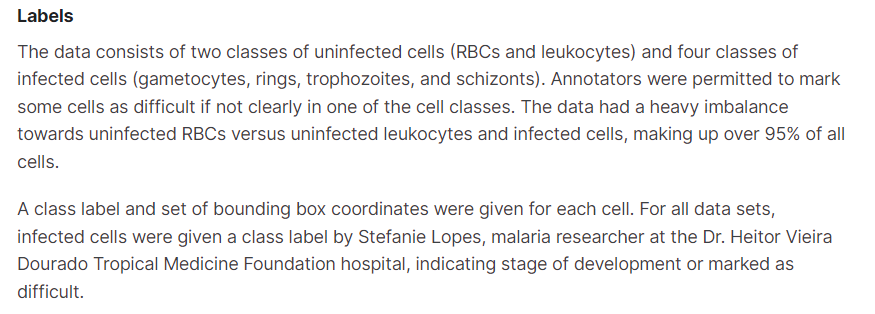

In [6]:
object_df = pd.DataFrame([dict(image=c_row['path'], **c_item) for _, c_row in train_df.iterrows() for c_item in c_row['objects']])
cat_dict = {v:k for k,v in enumerate(object_df['category'].value_counts().index, 1)}
print(object_df['category'].value_counts())
object_df.sample(3)

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: category, dtype: int64


image  \
47518  ../raw_data/task_1/vivax_binary/images/adff132...   
62431  ../raw_data/task_1/vivax_binary/images/9af1ee0...   
15244  ../raw_data/task_1/vivax_binary/images/dd7142e...   

                                            bounding_box        category  
47518  {'minimum': {'r': 188, 'c': 1134}, 'maximum': ...  red blood cell  
62431  {'minimum': {'r': 712, 'c': 17}, 'maximum': {'...  red blood cell  
15244  {'minimum': {'r': 57, 'c': 142}, 'maximum': {'...  red blood cell

# Load and Preview
Here we can load and preview a single row

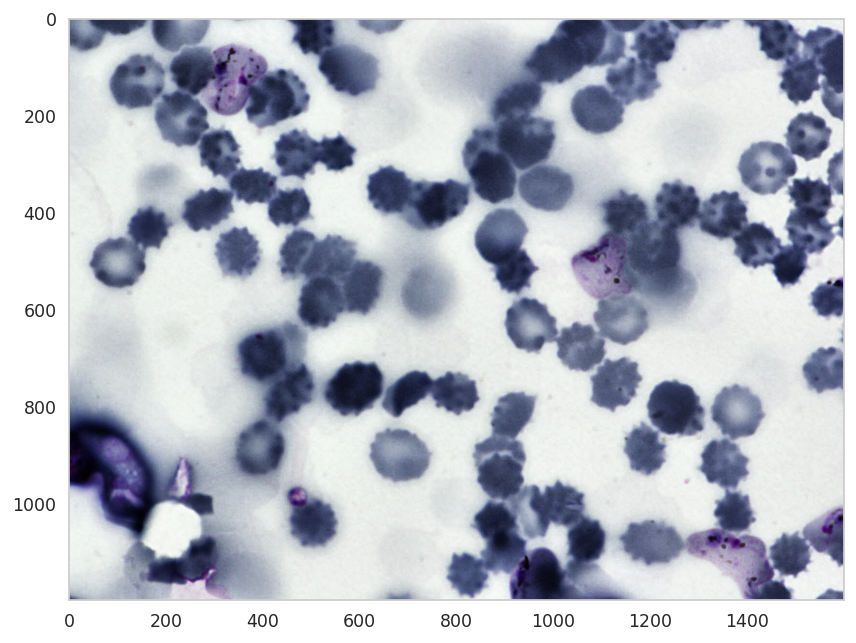

In [7]:
plt.imshow(imread(train_df.iloc[0]['path']))

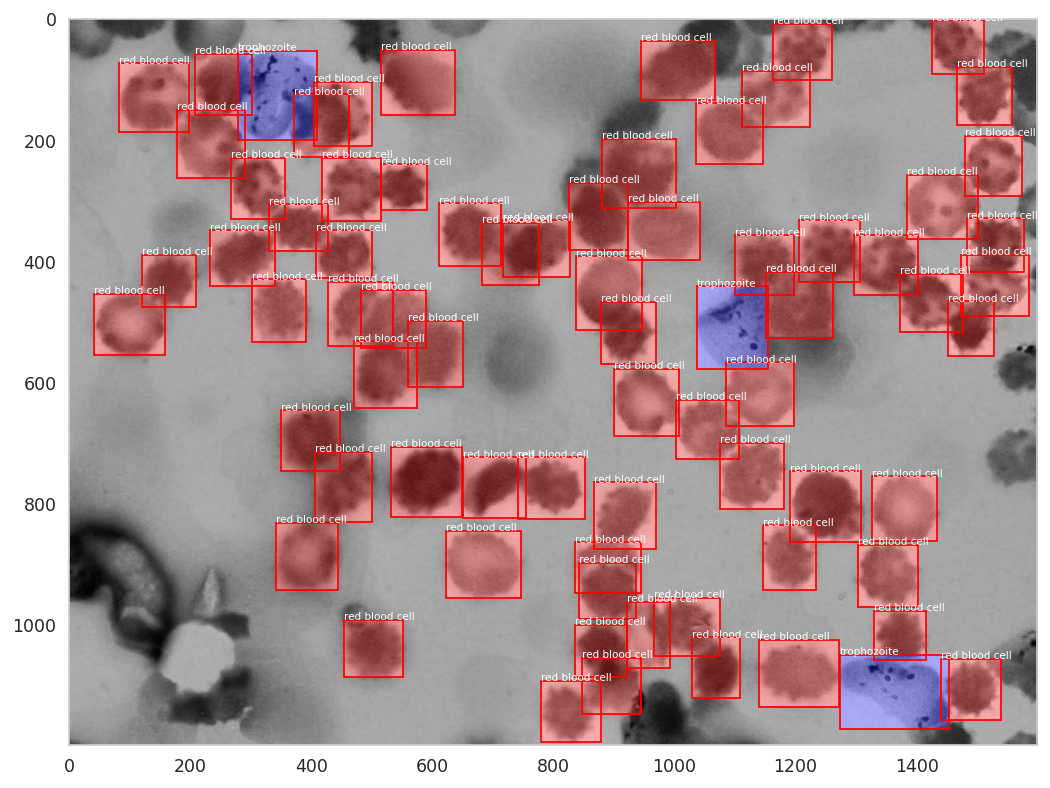

In [8]:
test_row = train_df.iloc[0]
def show_image_boxes(in_row, ax=None):
    """Show a row with bounding boxes"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    c_img = imread(in_row['path'])
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
    
    for c_obj in in_row['objects']:
        min_val = c_obj['bounding_box']['minimum']
        max_val = c_obj['bounding_box']['maximum']
        lab_id = cat_dict.get(c_obj['category'], 20)
        lab_img[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = lab_id
        
        box_label = str(c_obj['category'])
        box = patches.Rectangle((min_val['c'], min_val['r']), 
                                max_val['c'] - min_val['c'], 
                                max_val['r'] - min_val['r'], 
                                linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(box)
        ax.text(min_val['c'], min_val['r'], box_label, color='white', fontsize=6)
        
    
    ax.imshow(label2rgb(label=lab_img, image=c_img, bg_label=0))
    
    
show_image_boxes(test_row)

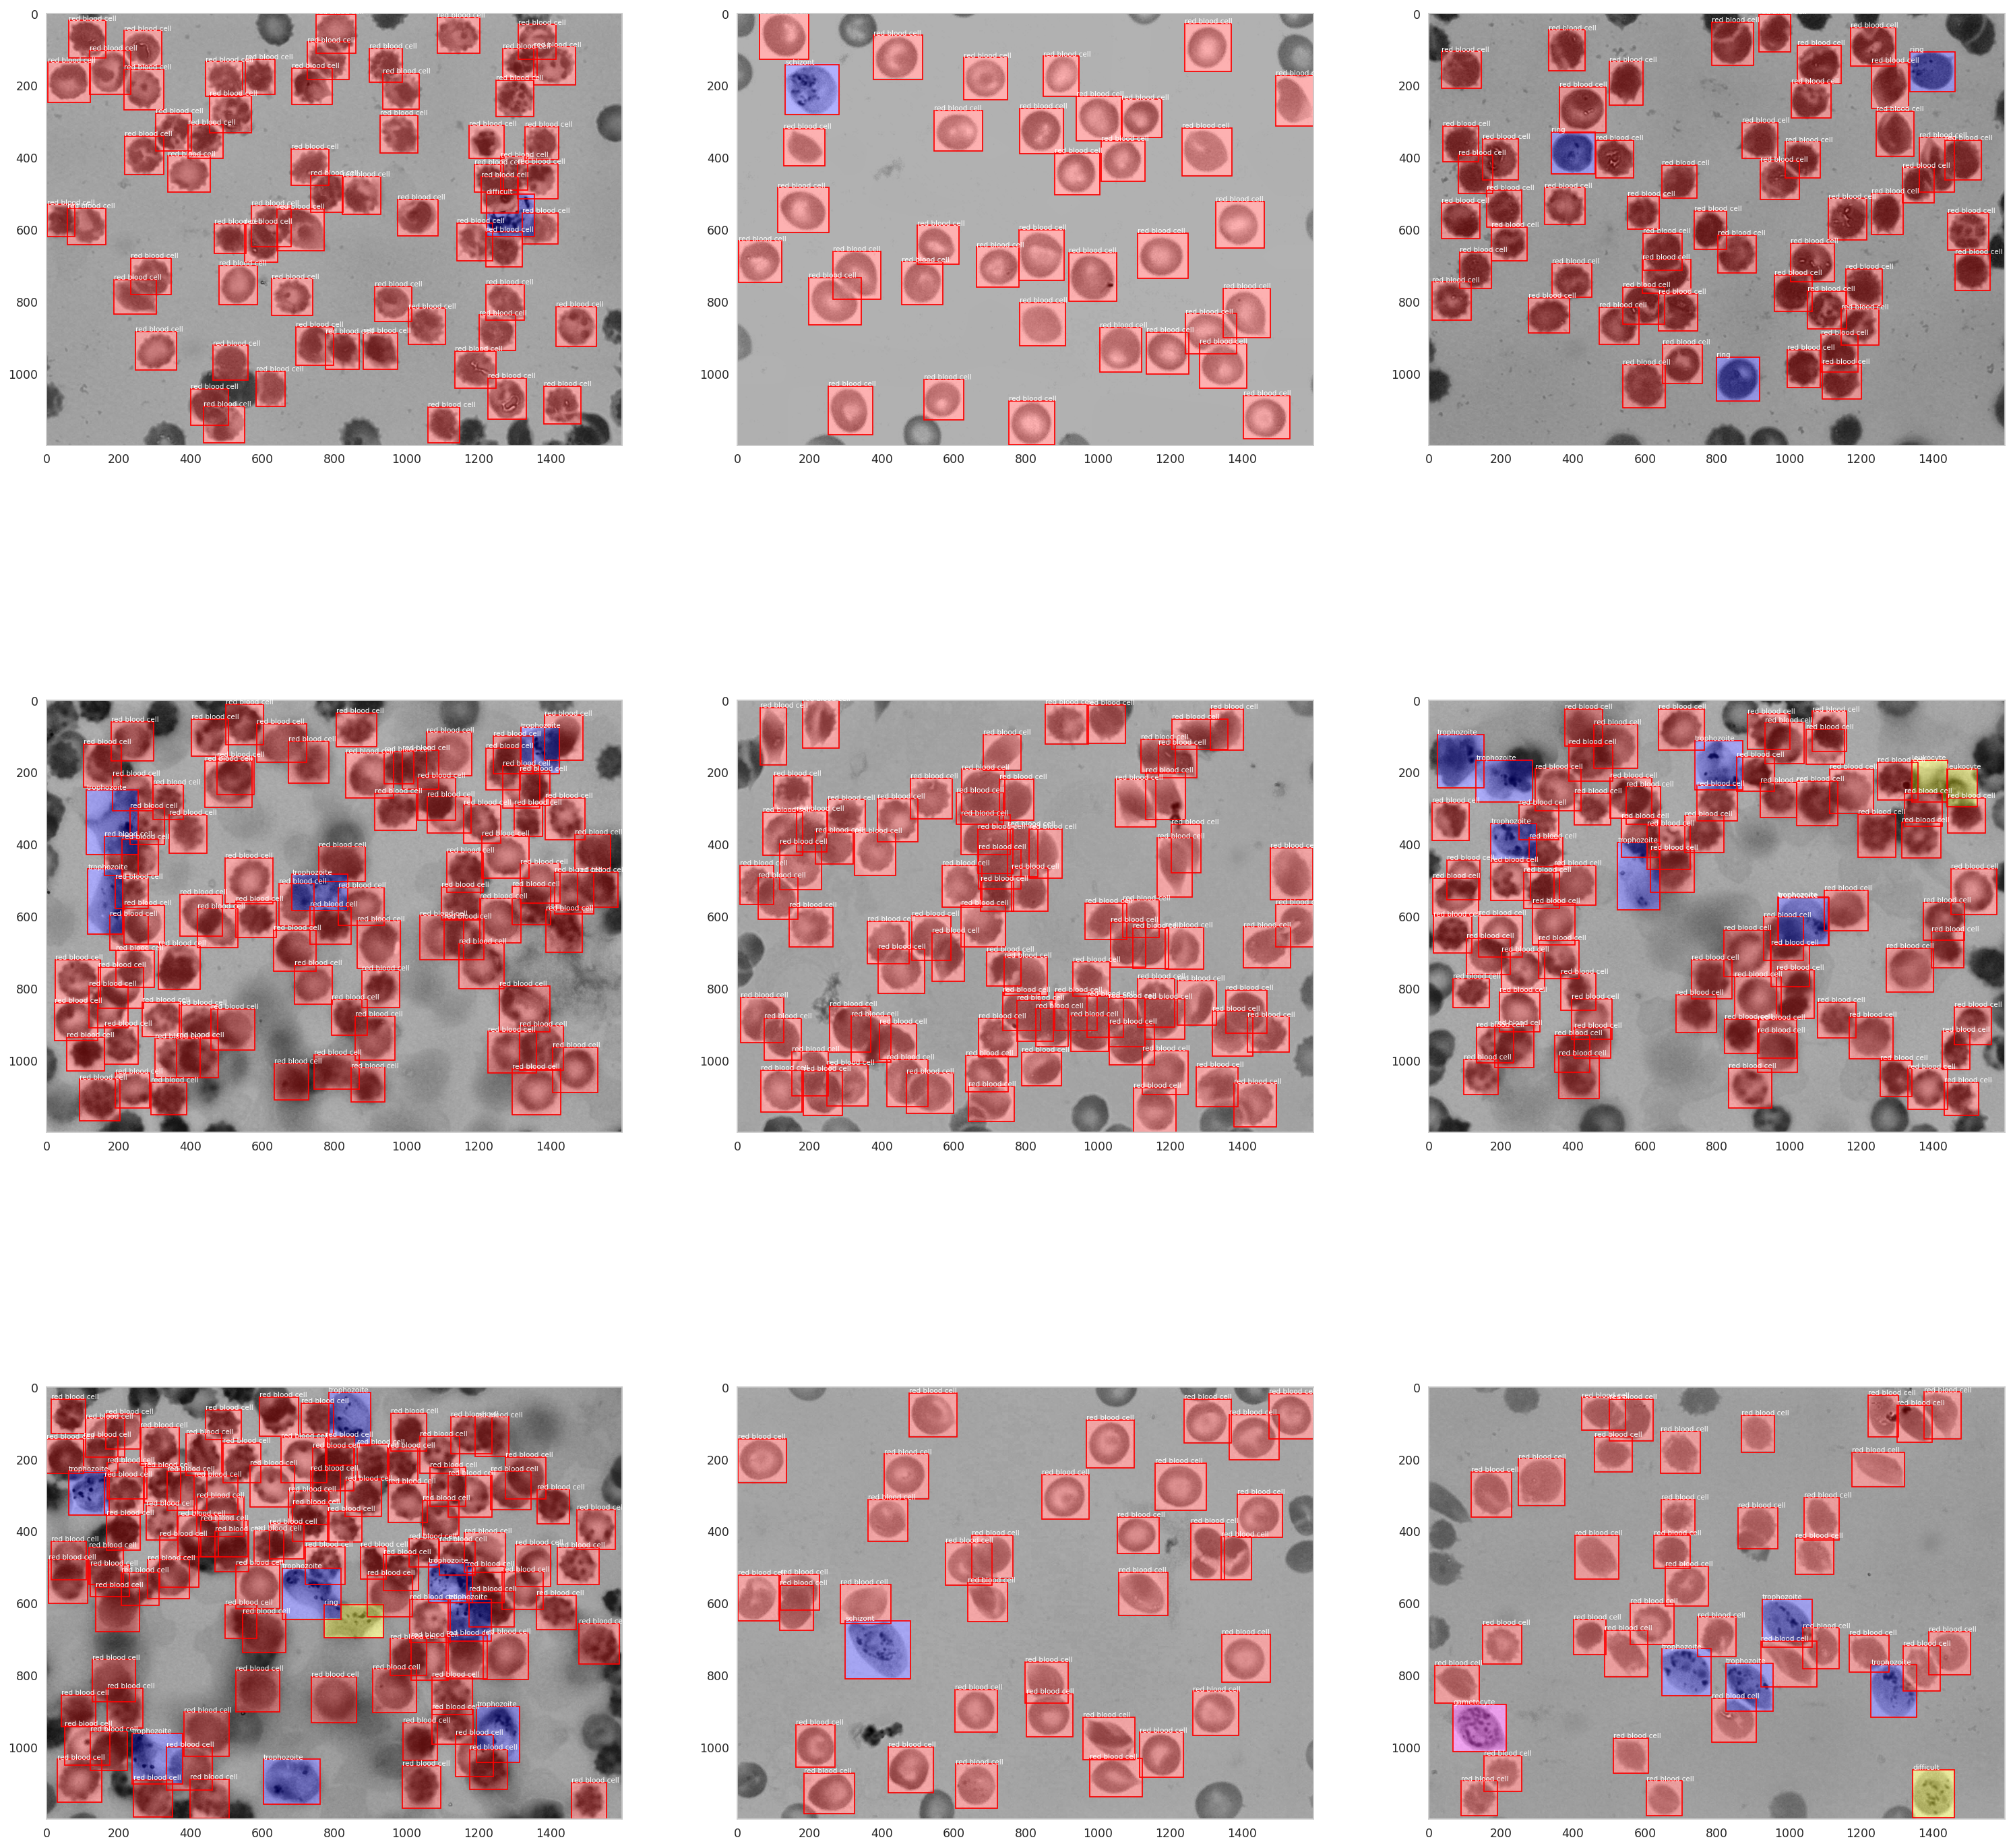

In [9]:
fig, m_axs = plt.subplots(3, 3, figsize=(30, 30))
valid_img_list = object_df.groupby('category').apply(lambda x: x.sample(2)).reset_index(drop=True)['image'].values.tolist()
for c_ax, (_, c_row) in zip(m_axs.flatten(), train_df[train_df['path'].isin(valid_img_list)].iterrows()):
    show_image_boxes(c_row, ax=c_ax)

In [10]:
fig.savefig(malaria_dir_str + 'overlay_figure.png')